In [6]:
!pip install -U scikit-activeml

In [7]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import QueryByCommittee, RandomSampling, UncertaintySampling
from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_decision_boundary, plot_utilities
from sklearn.datasets import load_digits, load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [8]:
# Load datasets
iris = load_iris()
digits = load_digits()

In [9]:
from sklearn.metrics import f1_score


def evaluate_active_learning(datasets):

    for dataset_name, (X, y_true) in datasets.items():

        print(f"Evaluating dataset: {dataset_name}")

        clf = SklearnClassifier(RandomForestClassifier(), classes=np.unique(y_true))

        methods = [
            "margin_sampling",
            "entropy",
            "least_confident",
            "random_sampling",
            "KL_divergence",
        ]

        n_cycles = 100

        accuracies = {method: [] for method in methods}
        f1_scores = {method: [] for method in methods}

        for method in methods:

            if method in ["random_sampling"]:

                qs = RandomSampling(random_state=42)

            elif method in ["KL_divergence"]:

                qs = QueryByCommittee(random_state=42, method=method)

            else:

                qs = UncertaintySampling(method=method, random_state=42)

            y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

            clf.fit(X, y)

            for c in range(n_cycles):

                if method in ["random_sampling"]:

                    query_idx = qs.query(X=X, y=y, batch_size=1)

                elif method in ["KL_divergence"]:

                    query_idx = qs.query(X=X, y=y, ensemble=clf, batch_size=1)

                else:

                    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)

                y[query_idx] = y_true[query_idx]

                clf.fit(X, y)

                accuracy = clf.score(X, y_true)

                accuracies[method].append(accuracy)
                f1 = f1_score(y_true, clf.predict(X), average="weighted")
                f1_scores[method].append(f1)

        # Print accuracies for each method

        print(f"Accuracies for dataset: {dataset_name}")

        for method, accuracy in accuracies.items():
            print(f"  Method: {method}, Accuracy: {accuracy[-1]:.4f}")
        for method, f1 in f1_scores.items():
            print(f"  Method: {method}, F1: {f1[-1]:.4f}")

        # Plot accuracies

        plt.figure(figsize=(10, 6))

        max_accuracy = 0

        best_method = ""

        for method, accuracy in accuracies.items():

            plt.plot(range(1, n_cycles + 1), accuracy, label=method, marker="o")
            if accuracy[-1] > max_accuracy:
                max_accuracy = accuracy[-1]

        max_f1 = 0
        # Plot f1 scores
        for method, f1 in f1_scores.items():
            plt.plot(range(1, n_cycles + 1), f1, label=f"{method} (F1)", linestyle="--")
            if f1[-1] > max_f1:
                max_f1 = f1[-1]
                best_method = method

        plt.title(f"Accuracy vs Iterations - {dataset_name}")

        plt.xlabel("Iterations")

        plt.ylabel("Accuracy")

        plt.legend()

        plt.grid(True)

        plt.show()

        # Print the method with the highest accuracy
        print(
            f"The method with the highest accuracy for dataset {dataset_name} is {best_method} with an accuracy of {max_accuracy:.4f}.\n"
        )

Evaluating dataset: Iris


Accuracies for dataset: Iris
  Method: margin_sampling, Accuracy: 1.0000
  Method: entropy, Accuracy: 1.0000
  Method: least_confident, Accuracy: 1.0000
  Method: random_sampling, Accuracy: 0.9867
  Method: KL_divergence, Accuracy: 1.0000
  Method: margin_sampling, F1: 1.0000
  Method: entropy, F1: 1.0000
  Method: least_confident, F1: 1.0000
  Method: random_sampling, F1: 0.9867
  Method: KL_divergence, F1: 1.0000


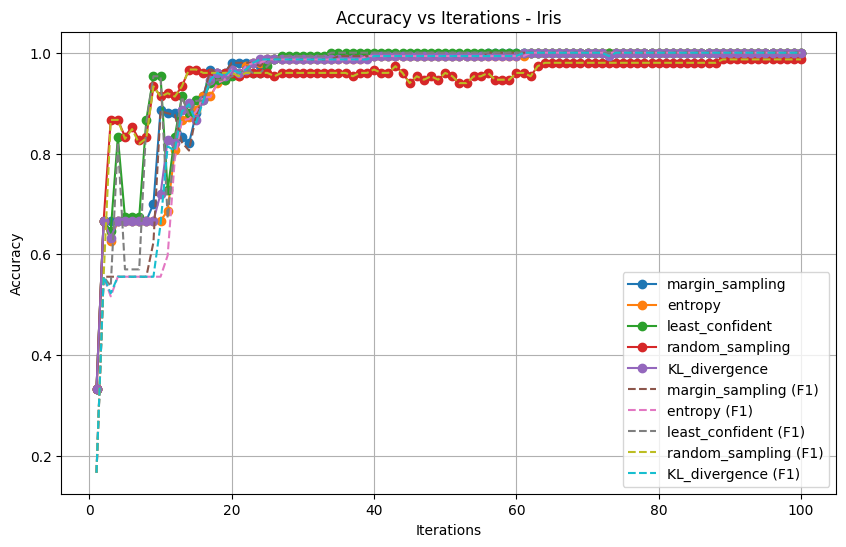

The method with the highest accuracy for dataset Iris is margin_sampling with an accuracy of 1.0000.

Evaluating dataset: Digits
Accuracies for dataset: Digits
  Method: margin_sampling, Accuracy: 0.9382
  Method: entropy, Accuracy: 0.8859
  Method: least_confident, Accuracy: 0.9015
  Method: random_sampling, Accuracy: 0.8653
  Method: KL_divergence, Accuracy: 0.8742
  Method: margin_sampling, F1: 0.9386
  Method: entropy, F1: 0.8866
  Method: least_confident, F1: 0.9017
  Method: random_sampling, F1: 0.8566
  Method: KL_divergence, F1: 0.8738


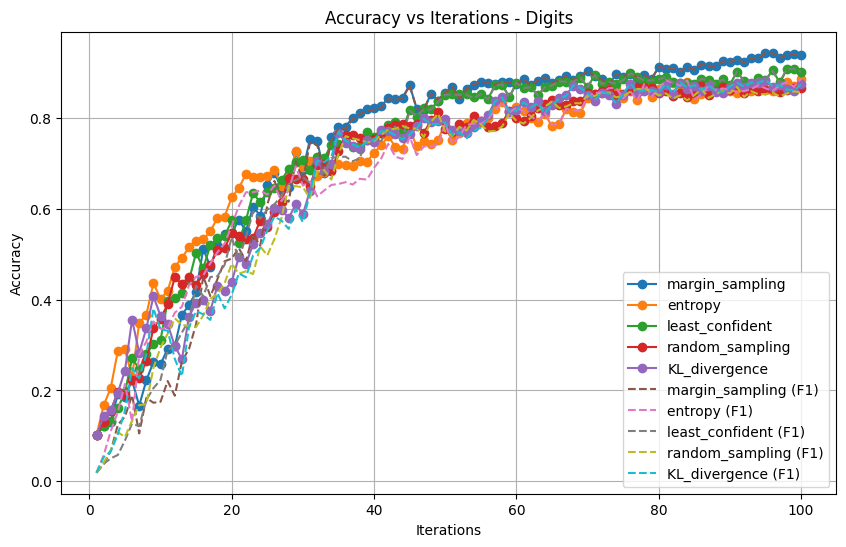

The method with the highest accuracy for dataset Digits is margin_sampling with an accuracy of 0.9382.



In [10]:
# Define datasets
datasets = {"Iris": (iris.data, iris.target), "Digits": (digits.data, digits.target)}
# Call the function
evaluate_active_learning(datasets)